In [1]:
import sys
sys.path.append('../..')
from src.pomdp import *

import pandas as pd
import numpy as np
import cupy as cp

In [2]:
from cupy.cuda import runtime as cuda_runtime
cuda_runtime.setDevice(3)

# Model definition

In [3]:
olf_stats = np.load('./Data/statistics_nose_3e6_27_123.npy')

In [4]:
olf_shape = olf_stats.shape
margins = [14, 62]

height = olf_shape[0] + margins[0]*2
width = olf_shape[1] + margins[1]*2

env_shape = [height, width]
state_count = width * height
print(f'Environment shape: {env_shape}')
print(f'State count: {state_count}')

Environment shape: [56, 247]
State count: 13832


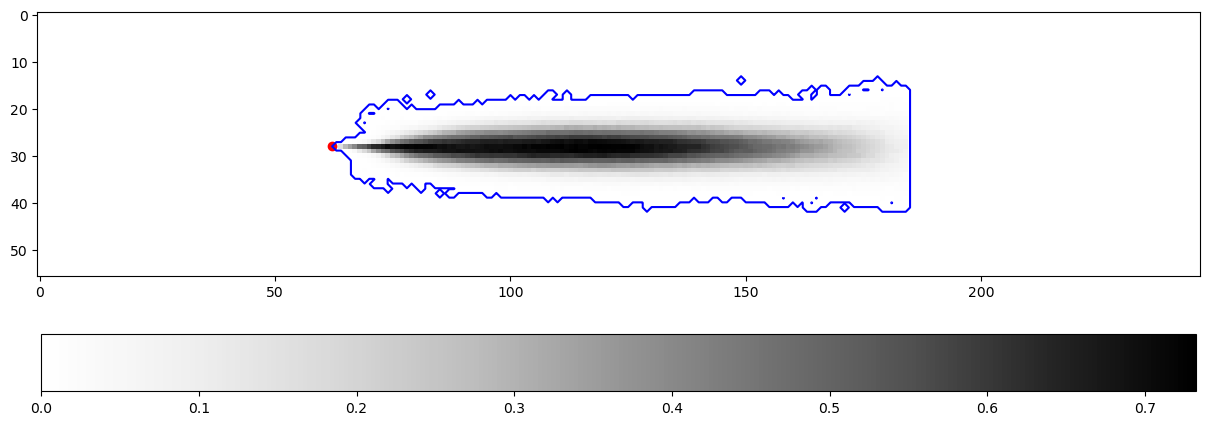

In [5]:
nose_data = np.zeros(env_shape)

nose_data[margins[0]:margins[0]+olf_shape[0], margins[1]:margins[1]+olf_shape[1]] = olf_stats

plt.figure(figsize=(15,5))
plt.imshow(nose_data, cmap='Greys')
plt.colorbar(location='bottom', orientation='horizontal')
plt.contour(nose_data>0, levels=[0.1], colors='blue')
plt.scatter(62,28, c='red')

In [6]:
# goal states
source = [28,62]
goal_state = (source[0] * env_shape[1]) + source[1]

print(f'Goal state: {goal_state}')

Goal state: 6978


In [7]:
# observation matrix
observations = np.empty((state_count, 5, 3)) # 5-actions, 3-observations

# obs 0: Nothing observed, obs 1: Something observed, obs 2: source found

observations[:,:,0] = (1 - nose_data.ravel()[:,None])
observations[:,:,1] = nose_data.ravel()[:,None]

# Detection of goal
observations[:,:,2] = 0.0
observations[goal_state,:,:] = 0.0
observations[goal_state,:,2] = 1.0

In [8]:
# states
state_grid = []

# State labels
for i in range(env_shape[0]):
    i_states = []
    for j in range(env_shape[1]):
        i_states.append(f's_{i}_{j}')

    state_grid.append(i_states)

In [9]:
# Reachable states
row_w = env_shape[1]

reachable_states = np.zeros((state_count, 5, 1), dtype=int)
for s in range(state_count):
    reachable_states[s,0,0] = s - row_w if s - row_w >= 0 else (state_count - row_w) + s # North
    reachable_states[s,1,0] = s + 1 if (s + 1) % row_w > 0 else s # East
    reachable_states[s,2,0] = s + row_w if s + row_w < state_count else s % row_w # South
    reachable_states[s,3,0] = s - 1 if (s - 1) % row_w < (row_w - 1) else s # West
    reachable_states[s,4,0] = s # Doesn't move

reachable_states = np.array(reachable_states)

In [10]:
# Reward function
def reward_func(s,a,sn,o):
    return np.where(sn == goal_state, 1.0, 0.0)

In [11]:
# Start belief
start = (nose_data > 0).astype(float)
start /= np.sum(start)

In [12]:
# Computing end states in radius of source
source_radius = 2
end_states = np.argwhere(np.fromfunction(lambda x,y: ((x-source[0])**2 + (y-source[1])**2) <= source_radius**2, shape=env_shape).ravel())[:,0].tolist()

for es in end_states:
    reverse_index = np.unravel_index(es, shape=env_shape)
    print(f'{es} - [{reverse_index[0]}, {reverse_index[1]}]')

6484 - [26, 62]
6730 - [27, 61]
6731 - [27, 62]
6732 - [27, 63]
6976 - [28, 60]
6977 - [28, 61]
6978 - [28, 62]
6979 - [28, 63]
6980 - [28, 64]
7224 - [29, 61]
7225 - [29, 62]
7226 - [29, 63]
7472 - [30, 62]


In [13]:
model = Model(
    states=state_grid,
    actions=['N','E','S','W','O'],
    observations=['nothing','something','goal'],
    reachable_states=reachable_states,
    # rewards=reward_func,
    observation_table=observations,
    end_states=end_states,
    start_probabilities=start.ravel()
)

[02/07/2024, 13:56:38] Instantiation of MDP Model:
[02/07/2024, 13:56:38] - 13832 states
[02/07/2024, 13:56:38] - 5 actions
[02/07/2024, 13:56:38] - At most 1 reachable states per state-action pair
[02/07/2024, 13:56:38] - Starting generation of transitions table
[02/07/2024, 13:56:38]     > [Warning] No transition matrix or function provided but reachable states are, so probability to reach any reachable states will "1 / reachable state count" so here: 1.000.
[02/07/2024, 13:56:38]     > Done in 0.000s
[02/07/2024, 13:56:38] - Generation of state grid
[02/07/2024, 13:56:38] - Generating start probabilities table
[02/07/2024, 13:56:38] - Starting computation of reachable state probabilities from transition data
[02/07/2024, 13:56:38]     > Done in 0.000s

[02/07/2024, 13:56:38] POMDP particular parameters:
[02/07/2024, 13:56:38] - 3 observations
[02/07/2024, 13:56:38] - Starting of transitional observations for reachable states table
[02/07/2024, 13:56:38]     > Done in 0.004s
[02/07/2

In [14]:
model.save('Nose_Only_27_123')

# MDP solution

In [15]:
vi_solver = VI_Solver(eps=1e-6)
mdp_solution, hist = vi_solver.solve(model, use_gpu=True)

print(hist.summary)

[02/07/2024, 13:56:41] Sending Model to GPU...


[02/07/2024, 13:56:41]     > Done in 0.239s


  0%|          | 0/10000 [00:00<?, ?it/s]

Summary of Value Iteration run
  - Model: 13832-state, 5-action
  - Converged in 918 iterations and 0.7217 seconds
  - Took on average 0.0008s per iteration


[Warning] Value function on GPU, converting to numpy before plotting...
[Warning] 'as_grid' parameter set to False but state count is >3 so it will be plotted as a grid


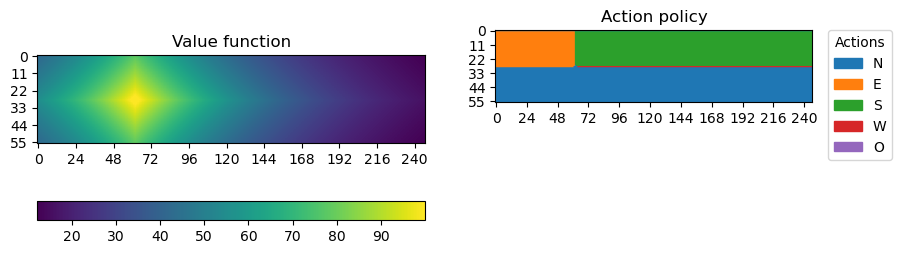

In [16]:
mdp_solution.plot()

# FSVI Solving

In [17]:
fsvi_solver = FSVI_Solver(0.99, eps=1e-6)

In [18]:
fsvi_solution, hist = fsvi_solver.solve(model=model,
                                        expansions=600,
                                        max_belief_growth=100,
                                        # prune_level=2, # Useless because of belief domination
                                        # prune_interval=25,
                                        # history_tracking_level=2,
                                        use_gpu=True)
print(hist.summary)

[02/07/2024, 13:56:46] [Warning] MDP solution not provided, running value iteration on the problem to retrieve it...
[02/07/2024, 13:56:46]     > Starting MDP Value Iteration...


[02/07/2024, 13:56:47]     > Value Iteration stopped or converged in 0.731s, and after 918 iteration.



Expansions:   0%|          | 0/600 [00:00<?, ?it/s]

Memory full: Out of memory allocating 22,321,528,320 bytes (allocated so far: 74,603,315,200 bytes).
Returning value function and history as is...

Summary of Value Iteration run
  - Model: 13832 state, 5 action, 3 observations
  - Converged or stopped after 464 expansion steps and 463 backup steps.
  - Resulting value function has 13448 alpha vectors.
  - Converged in 301.9869s

  - Expand function took on average 0.0603s and yielded on average 69.31 beliefs per iteration. (0.0009s/it/belief)
  - Backup function took on average 0.5918s and yielded on average 29.03 alpha vectors per iteration. (0.0003s/it/alpha)
  - Pruning function took on average 0.0000s and yielded on average prunings of 0.00 alpha vectors per iteration.


[Warning] Value function on GPU, converting to numpy before plotting...


[Warning] 'as_grid' parameter set to False but state count is >3 so it will be plotted as a grid


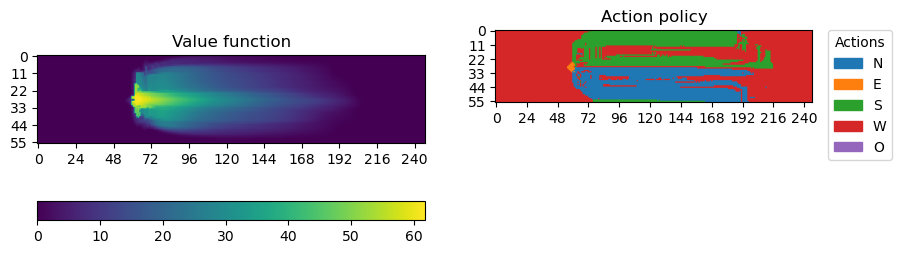

In [19]:
fsvi_solution.plot()

In [20]:
fsvi_solution.save_parquet()

# Run grid test

In [ ]:
vf = ValueFunction.load_from_parquet('./ValueFunctions/20240207_140313_value_function.parquet', model)